In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random

In [131]:
from scipy.stats import ks_2samp, wasserstein_distance

In [132]:
input=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/with all the outputs/2025-09-11/17-17-04/inputs.npy", mmap_mode='r')
output=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/with all the outputs/2025-09-11/17-17-04/outputs.npy", mmap_mode='r')

In [133]:
output1=output[:,1,:,:,:]

In [134]:
input_hcp=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/with all the outputs/2025-09-11/17-17-04/hcp/inputs.npy")
output_hcp=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/with all the outputs/2025-09-11/17-17-04/hcp/outputs.npy")

input_epilepsy=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/with all the outputs/2025-09-11/17-17-04/epilepsy_PBS/inputs.npy")
output_epilepsy=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/with all the outputs/2025-09-11/17-17-04/epilepsy_PBS/outputs.npy")

In [135]:
output1_hcp=output_hcp[:,1,:,:,:]
output1_epilepsy=output_epilepsy[:,1,:,:,:]

In [136]:
index_irm_neg = [19,21,26,28,31,34,35,38,40,41,43,44,45]
index_irm_pos=[20,22,23,24,25,27,29,30,32,33,36,37,39,42,46,47,48,49,50,51,52,53,54,55,56]

In [137]:
input=input[:,0,:,:,:]

In [138]:
input_hcp=input_hcp[:,0,:,:,:]
input_epilepsy=input_epilepsy[:,0,:,:,:]

In [139]:
mean_input= np.mean(input, axis=0)

In [140]:
coords = np.where(mean_input > 0)
amin, amax = coords[0].min(), coords[0].max()
bmin, bmax = coords[1].min(), coords[1].max()
cmin, cmax = coords[2].min(), coords[2].max()

input_restricted = input[:1000, amin:amax+1, bmin:bmax+1, cmin:cmax+1]
output_restricted = output1[:1000, amin:amax+1, bmin:bmax+1, cmin:cmax+1]

input_hcp_restricted = input_hcp[:, amin:amax+1, bmin:bmax+1, cmin:cmax+1]
output_hcp_restricted = output1_hcp[:, amin:amax+1, bmin:bmax+1, cmin:cmax+1]

input_epilepsy_restricted = input_epilepsy[:, amin:amax+1, bmin:bmax+1, cmin:cmax+1]
output_epilepsy_restricted = output1_epilepsy[:, amin:amax+1, bmin:bmax+1, cmin:cmax+1]

In [141]:
input_control_restricted= input_epilepsy_restricted[0:19,:,:,:]
output_control_restricted= output_epilepsy_restricted[0:19,:,:,:]

input_neg_restricted= input_epilepsy_restricted[index_irm_neg,:,:,:]
output_neg_restricted= output_epilepsy_restricted[index_irm_neg,:,:,:]

input_pos_restricted= input_epilepsy_restricted[index_irm_pos,:,:,:]
output_pos_restricted= output_epilepsy_restricted[index_irm_pos,:,:,:]

In [142]:
def restricted(Input, Output):
    Input=Input[:,:-1,:-1,:-1]
    Output=Output[:,:-1,:-1,:-1]

    return Input, Output

In [143]:
eps = 1e-20
beta=2/3

In [144]:
def compute_cross_entropy(Input, Output): #Input and Output with shape (n,a,b,c)

    loss = -beta*Input * np.log(Output + eps) - (1-beta)*(1 - Input) * np.log(1 - Output + eps)

    loss_per_subject = np.mean(loss, axis=(1, 2, 3))  # shape (n,)
    loss_mean = np.mean(loss_per_subject)
    return loss_mean, loss_per_subject

In [145]:
from scipy.stats import mannwhitneyu

In [146]:
def distance_hcp_control_neg_pos(I_hcp, O_hcp, I_control, O_control, I_neg, O_neg, I_pos, O_pos):
    loss_mean_hcp, loss_per_subject_hcp = compute_cross_entropy(I_hcp, O_hcp)
    loss_mean_control, loss_per_subject_control = compute_cross_entropy(I_control, O_control)
    loss_mean_neg, loss_per_subject_neg = compute_cross_entropy(I_neg, O_neg)
    loss_mean_pos, loss_per_subject_pos = compute_cross_entropy(I_pos, O_pos)

    d_hcp_control = abs(loss_mean_hcp- loss_mean_control)/(loss_mean_hcp+ loss_mean_control)
    d_control_neg = abs(loss_mean_neg- loss_mean_control)/(loss_mean_neg+ loss_mean_control)
    d_control_pos = abs(loss_mean_pos- loss_mean_control)/(loss_mean_pos+ loss_mean_control)

    stat1, p_hcp_control = mannwhitneyu(loss_per_subject_hcp, loss_per_subject_control, alternative='two-sided')
    stat2, p_control_neg = mannwhitneyu(loss_per_subject_control, loss_per_subject_neg, alternative='two-sided')
    stat3, p_control_pos = mannwhitneyu(loss_per_subject_control, loss_per_subject_pos, alternative='two-sided')

    return d_hcp_control, d_control_neg, d_control_pos, -np.log10(p_hcp_control), -np.log10(p_control_neg), -np.log10(p_control_pos)

In [147]:
def statistic_distance(I_hcp, O_hcp, I_control, O_control, I_neg, O_neg, I_pos, O_pos):
    loss_mean_hcp, loss_per_subject_hcp = compute_cross_entropy(I_hcp, O_hcp)
    loss_mean_control, loss_per_subject_control = compute_cross_entropy(I_control, O_control)
    loss_mean_neg, loss_per_subject_neg = compute_cross_entropy(I_neg, O_neg)
    loss_mean_pos, loss_per_subject_pos = compute_cross_entropy(I_pos, O_pos)

    ks_hcp_control= ks_2samp(loss_per_subject_hcp, loss_per_subject_control).statistic
    ks_control_neg= ks_2samp(loss_per_subject_neg, loss_per_subject_control).statistic
    ks_control_pos= ks_2samp(loss_per_subject_pos, loss_per_subject_control).statistic

    wa_hcp_control= wasserstein_distance(loss_per_subject_hcp, loss_per_subject_control)
    wa_control_neg= wasserstein_distance(loss_per_subject_neg, loss_per_subject_control)
    wa_control_pos= wasserstein_distance(loss_per_subject_pos, loss_per_subject_control)

    return ks_hcp_control,ks_control_neg, ks_control_pos, wa_hcp_control, wa_control_neg, wa_control_pos

In [148]:
L_d_hcp_control = []
L_d_control_neg = []
L_d_control_pos = []

L_p_hcp_control = []
L_p_control_neg = []
L_p_control_pos =[]

L_ks_hcp_control=[]
L_ks_control_neg=[]
L_ks_control_pos=[]

L_wa_hcp_control=[]
L_wa_control_neg=[]
L_wa_control_pos=[]

a,b,c,d,e,f= distance_hcp_control_neg_pos(input_hcp_restricted, output_hcp_restricted, input_control_restricted, output_control_restricted, input_neg_restricted, output_neg_restricted, input_pos_restricted, output_pos_restricted )
L_d_hcp_control.append(a)
L_d_control_neg.append(b)
L_d_control_pos.append(c)

L_p_hcp_control.append(d)
L_p_control_neg.append(e)
L_p_control_pos.append(f)

a,b,c,d,e,f= statistic_distance(input_hcp_restricted, output_hcp_restricted, input_control_restricted, output_control_restricted, input_neg_restricted, output_neg_restricted, input_pos_restricted, output_pos_restricted )
L_ks_hcp_control.append(a)
L_ks_control_neg.append(b)
L_ks_control_pos.append(c)

L_wa_hcp_control.append(d)
L_wa_control_neg.append(e)
L_wa_control_pos.append(f)

print(input_restricted.shape)

while (len(output_hcp_restricted[0])>6) and (len(output_hcp_restricted[0][0])>6) and (len(output_hcp_restricted[0][0][0])>6):

    #input_restricted, output_restricted = restricted(axis, input_restricted, output_restricted)
    input_hcp_restricted, output_hcp_restricted = restricted(input_hcp_restricted, output_hcp_restricted)
    input_control_restricted, output_control_restricted = restricted(input_control_restricted, output_control_restricted)
    input_neg_restricted, output_neg_restricted = restricted(input_neg_restricted, output_neg_restricted)
    input_pos_restricted, output_pos_restricted = restricted(input_pos_restricted, output_pos_restricted)
 
    a,b,c,d,e,f= distance_hcp_control_neg_pos(input_hcp_restricted, output_hcp_restricted, input_control_restricted, output_control_restricted, input_neg_restricted, output_neg_restricted, input_pos_restricted, output_pos_restricted )
    L_d_hcp_control.append(a)
    L_d_control_neg.append(b)
    L_d_control_pos.append(c)

    L_p_hcp_control.append(d)
    L_p_control_neg.append(e)
    L_p_control_pos.append(f)

    a,b,c,d,e,f= statistic_distance(input_hcp_restricted, output_hcp_restricted, input_control_restricted, output_control_restricted, input_neg_restricted, output_neg_restricted, input_pos_restricted, output_pos_restricted )
    L_ks_hcp_control.append(a)
    L_ks_control_neg.append(b)
    L_ks_control_pos.append(c)

    L_wa_hcp_control.append(d)
    L_wa_control_neg.append(e)
    L_wa_control_pos.append(f)
    print(input_hcp_restricted.shape)

(1000, 40, 34, 49)
(1114, 39, 33, 48)
(1114, 38, 32, 47)
(1114, 37, 31, 46)
(1114, 36, 30, 45)
(1114, 35, 29, 44)
(1114, 34, 28, 43)
(1114, 33, 27, 42)
(1114, 32, 26, 41)
(1114, 31, 25, 40)
(1114, 30, 24, 39)
(1114, 29, 23, 38)
(1114, 28, 22, 37)
(1114, 27, 21, 36)
(1114, 26, 20, 35)
(1114, 25, 19, 34)
(1114, 24, 18, 33)
(1114, 23, 17, 32)
(1114, 22, 16, 31)
(1114, 21, 15, 30)
(1114, 20, 14, 29)
(1114, 19, 13, 28)
(1114, 18, 12, 27)
(1114, 17, 11, 26)
(1114, 16, 10, 25)
(1114, 15, 9, 24)
(1114, 14, 8, 23)
(1114, 13, 7, 22)
(1114, 12, 6, 21)


In [149]:
global_d= np.array(L_d_control_neg) + np.array(L_d_control_pos) - np.array(L_d_hcp_control)

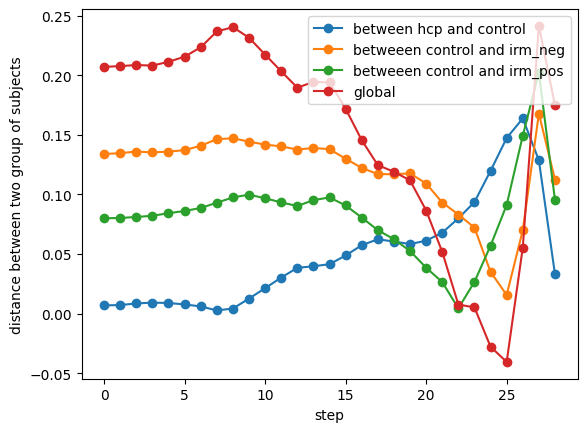

In [150]:
plt.plot(L_d_hcp_control, marker='o', linestyle='-', label="between hcp and control")
plt.plot(L_d_control_neg, marker='o', linestyle='-', label="betweeen control and irm_neg")
plt.plot(L_d_control_pos, marker='o', linestyle='-', label="betweeen control and irm_pos")
plt.plot(global_d, marker='o', linestyle='-', label="global")

plt.xlabel("step")
plt.ylabel("distance between two group of subjects")

plt.legend()
plt.show()


In [151]:
global_p= np.array(L_p_control_neg) + np.array(L_p_control_pos) - np.array(L_p_hcp_control)


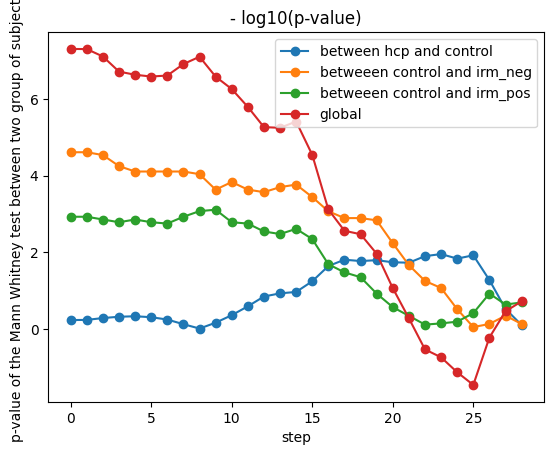

In [152]:
plt.plot(L_p_hcp_control, marker='o', linestyle='-', label="between hcp and control")
plt.plot(L_p_control_neg, marker='o', linestyle='-', label="betweeen control and irm_neg")
plt.plot(L_p_control_pos, marker='o', linestyle='-', label="betweeen control and irm_pos")
plt.plot(global_p, marker='o', linestyle='-', label="global")

plt.xlabel("step")
plt.ylabel("p-value of the Mann Whitney test between two group of subjects")
plt.title("- log10(p-value)")
plt.legend()
plt.show()

In [153]:
global_ks= np.array(L_ks_control_neg) + np.array(L_ks_control_pos) - np.array(L_ks_hcp_control)

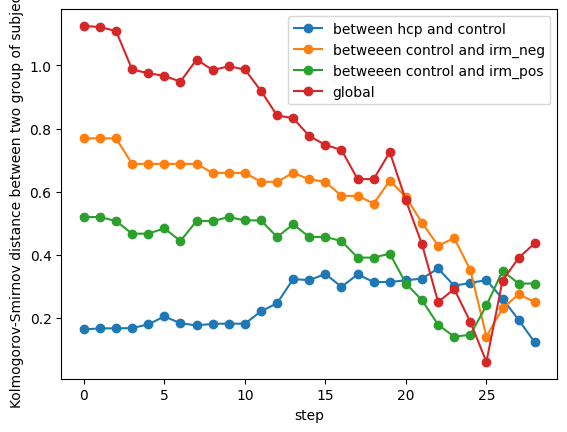

In [154]:
plt.plot(L_ks_hcp_control, marker='o', linestyle='-', label="between hcp and control")
plt.plot(L_ks_control_neg, marker='o', linestyle='-', label="betweeen control and irm_neg")
plt.plot(L_ks_control_pos, marker='o', linestyle='-', label="betweeen control and irm_pos")
plt.plot(global_ks, marker='o', linestyle='-', label="global")

plt.xlabel("step")
plt.ylabel("Kolmogorov-Smirnov distance between two group of subjects")
plt.legend()
plt.show()

In [155]:
global_wa= np.array(L_wa_control_neg) + np.array(L_wa_control_pos) - np.array(L_wa_hcp_control)

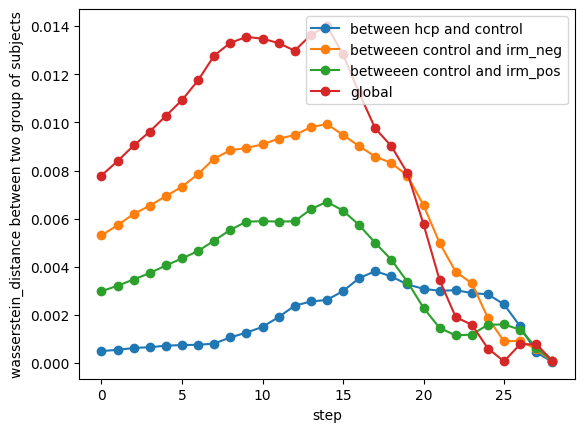

In [156]:
plt.plot(L_wa_hcp_control, marker='o', linestyle='-', label="between hcp and control")
plt.plot(L_wa_control_neg, marker='o', linestyle='-', label="betweeen control and irm_neg")
plt.plot(L_wa_control_pos, marker='o', linestyle='-', label="betweeen control and irm_pos")
plt.plot(global_wa, marker='o', linestyle='-', label="global")

plt.xlabel("step")
plt.ylabel("wasserstein_distance between two group of subjects")
plt.legend()
plt.show()